
# Predictive Modeling for Rider Retention

## Data Description

- `city`: City the user signed up in.
- `phone`: Primary device used by the user.
- `signup_date`: Date of account registration.
- `last_trip_date`: Date of the last trip.
- `avg_dist`: Average distance per trip in the first 30 days.
- `avg_rating_by_driver`: Average rating given by drivers to the rider.
- `avg_rating_of_driver`: Average rating given by the rider to drivers.
- `surge_pct`: Percentage of trips with a surge multiplier > 1.
- `avg_surge`: Average surge multiplier over all trips.
- `trips_in_first_30_days`: Number of trips in the first 30 days.
- `ultimate_black_user`: Whether the user took an Ultimate Black trip in their first 30 days.
- `weekday_pct`: Percentage of trips occurring during a weekday.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

In [49]:
# Load the dataset
df = pd.read_json('../data/ultimate_data_challenge.json')
display(df.head())

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [50]:
print(df.shape)
print(df.info())
print(df.describe())

(50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None
       trips_in_first_30_days  avg_rating_of_driver     avg_s

In [51]:
# Convert dates to datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [52]:
# Handle missing values
df = df.fillna({
    'avg_rating_by_driver': df['avg_rating_by_driver'].mean(),
    'avg_rating_of_driver': df['avg_rating_of_driver'].mean(),
    'phone': 'NA'
})

In [53]:
# Calculate retention (active in the last 30 days from the last date in the dataset)
last_date = df['last_trip_date'].max()
df['retained'] = (df['last_trip_date'] >= last_date - pd.Timedelta(days=30)).astype(int)

# Fraction of retained users
retention_rate = df['retained'].mean()
print(f"Retention Rate: {retention_rate:.2%}")

Retention Rate: 37.61%


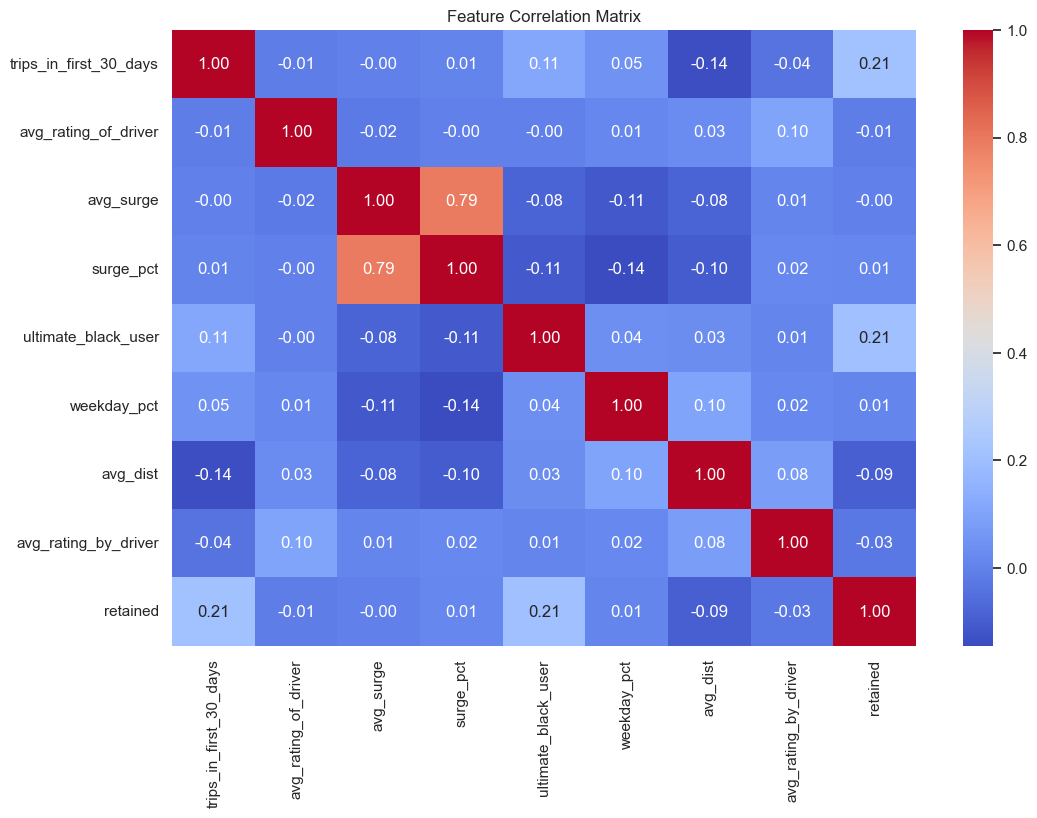

In [54]:
# Feature correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Matrix')
plt.show()


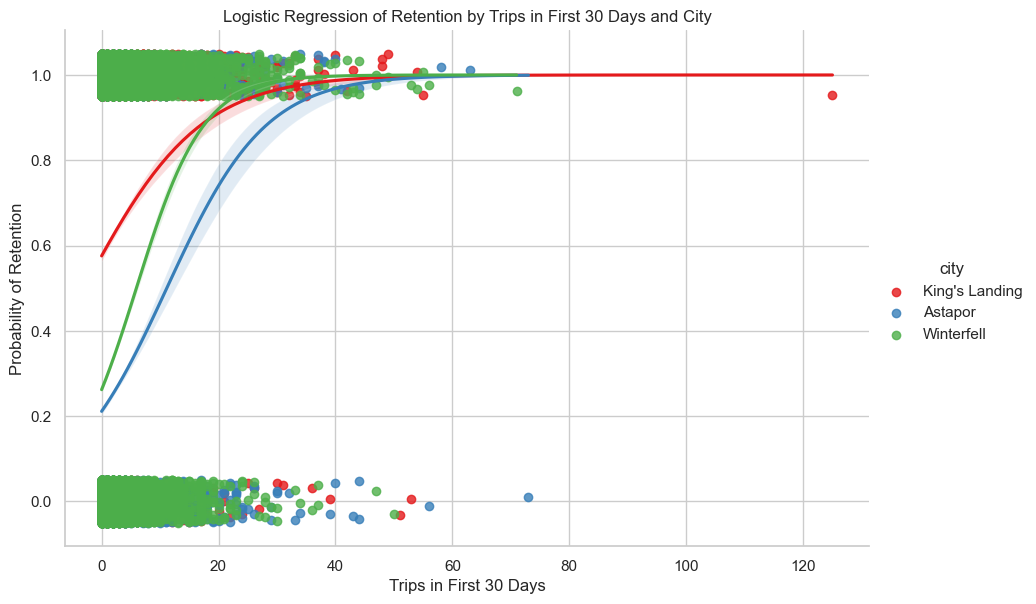

In [55]:
sns.set(style='whitegrid')

sns.lmplot(
    data=df, 
    x='trips_in_first_30_days',
    y='retained',
    hue='city',
    logistic=True,
    y_jitter=0.05,
    height=6,         # Set the height of the plot
    aspect=1.5,       # Set the aspect ratio
    palette='Set1'    # Use a distinct color palette
)

plt.xlabel('Trips in First 30 Days')
plt.ylabel('Probability of Retention')
plt.title('Logistic Regression of Retention by Trips in First 30 Days and City')

plt.show()

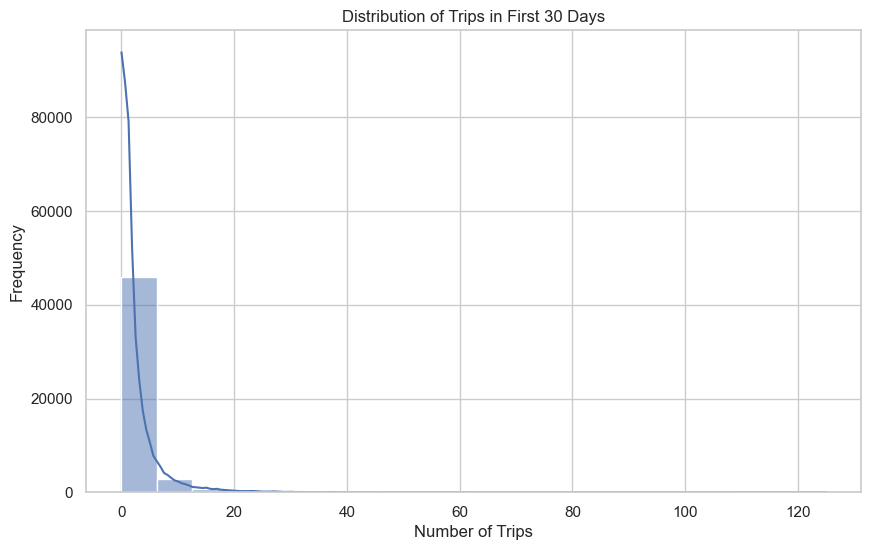

In [56]:
# Distribution of trips in the first 30 days
plt.figure(figsize=(10, 6))
sns.histplot(df['trips_in_first_30_days'], bins=20, kde=True)
plt.title('Distribution of Trips in First 30 Days')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.show()

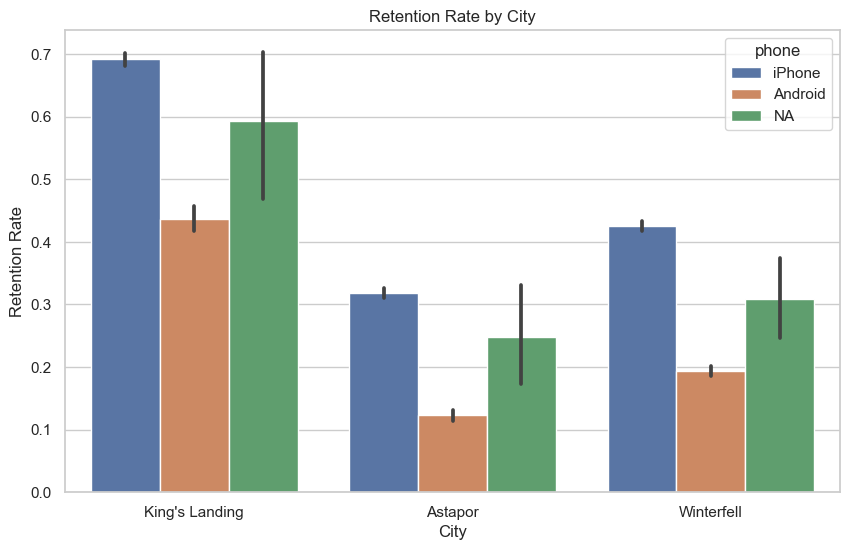

In [57]:
# Retention rate by city
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='retained', data=df,hue='phone')
plt.title('Retention Rate by City')
plt.xlabel('City')
plt.ylabel('Retention Rate')
plt.show()


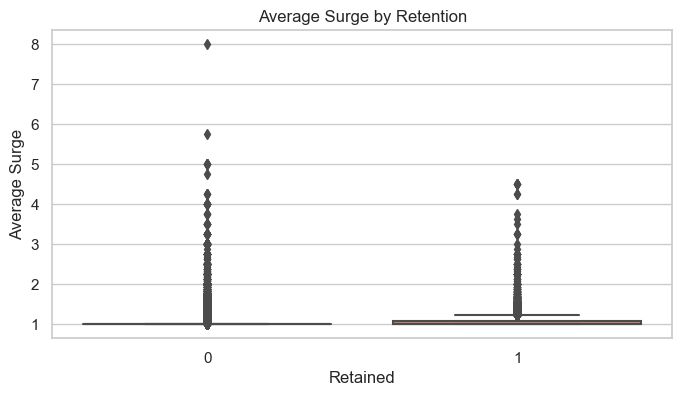

In [58]:

# Average surge by retention
plt.figure(figsize=(8, 4))
sns.boxplot(x='retained', y='avg_surge', data=df)
plt.title('Average Surge by Retention')
plt.xlabel('Retained')
plt.ylabel('Average Surge')
plt.show()


In [66]:
# Model Building
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['city','phone'], drop_first=True)

df_encoded.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_NA,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,0,0


In [77]:
# Define features and target
X = df_encoded.drop(columns=['signup_date', 'last_trip_date', 'retained'])
y = df_encoded['retained']

pipeline = Pipeline([
#    ('poly', PolynomialFeatures(degree=2, include_bias=True)),
    ('scaler', StandardScaler())
])

X_poly_scaled = pipeline.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MAE': mae, 'R²': r2}

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Display the evaluation results
print("Model Evaluation Results")
print(results_df)



Model Evaluation Results
                                  MAE        R²  Accuracy
Logistic Regression          0.283800 -0.211225  0.716200
Random Forest Regressor      0.301785  0.272231  0.272231
Gradient Boosting Regressor  0.312383  0.352884  0.352884
XGBoost                      0.297022  0.357924  0.357924


In [78]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


rf_accuracy = rf_model.score(X_test, y_test)


print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Insights and Recommendations
print("Suggestions for Ultimate:")
print("- Increase user engagement in the first month by promoting frequent usage and incentivizing weekday trips.")
print("- Monitor and optimize surge pricing strategies to enhance user experience.")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      9379
           1       0.67      0.66      0.66      5621

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000

Suggestions for Ultimate:
- Increase user engagement in the first month by promoting frequent usage and incentivizing weekday trips.
- Monitor and optimize surge pricing strategies to enhance user experience.
